---
## Technical Report Notebook 3
---
### Hail Modelling and Algorithm Investigation

The main analysis I wish to conduct is an investigation into the ability of tweets to predict hail events. This notebook will be broken down into the following sections:
1. Constructing the hail modelling - removing variables and creating the 'hail class'
2. Principle Component Analysis - investigating the variance in the predictors
3. Hail Modelling - investigating multiple classification algorithms and selecting an algorithm
4. Model Tuning and Evaluation

In [16]:
# Import modelling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
# Reading in data 

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

---

### 1. Construct Hail Tweet Investigation

The primary purpose of the modelling analysis is to develop an algorithm that can effectively classify tweets as being part of a hail event. 

If the word 'hail' is included in the tweet, then there is a very high chance it will indicate a hailing event. However.. what I really want to know is whether the rest of the tweet can effectviely classify this tweet if this term is removed.

I will investigate different classification algorithms and observe which provides the highest accuracy, precision and other key metrics.

#### Create Hail Class:

In [18]:
# Create hail class for classification analysis

hail_tweet_text['hail_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'hail_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'hail_class'] = 1

hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID'] == 144]
hail_tweet_text_syd = hail_tweet_text[hail_tweet_text['Cat_ID'] == 154]

In [20]:
# Create subsets of data for train/testing
htt_total = hail_tweet_text.ix[:,26:]
print ("Total:",htt_total.shape)

htt_bris = hail_tweet_text_bris.ix[:,26:]
print ("Brisbane:",htt_bris.shape)

htt_syd = hail_tweet_text_syd.ix[:,26:]
print ("Sydney:",htt_syd.shape)

# Create y-targets for each data/subset
y_total = htt_total.hail_class
y_bris = htt_bris.hail_class
y_syd = htt_syd.hail_class

(127989, 1000)
(46529, 1000)
(81460, 1000)


In [21]:
# Drop columns not needed as predictors:
# These include the main location text, as we want to be able to predict hail irrespective of location and
# Hail terms, as we want to be able to predict tweets referring to hailing when the term is unavailable

htt_total.drop(htt_total[['sydney','sydneystorm','brisbane','brisbanestorm',
                          'hail','hailstorm','hail_class']], axis=1, inplace=True)

htt_bris.drop(htt_bris[['sydney','sydneystorm','brisbane','brisbanestorm',
                        'hail','hailstorm','hail_class']], axis=1, inplace=True)

htt_syd.drop(htt_syd[['sydney','sydneystorm','brisbane','brisbanestorm',
                      'hail','hailstorm','hail_class']], axis=1, inplace=True)

----

### 2. Principle Component Analysis

I will now perform a PCA on my predictors to observe the variation. As I have a large set of predictors (1000) I will investigate whether a smaller number of uncorrelated variables, called "principal components", represent a large amount of variance in my dataset and if I can reduce the multicolinearity by reducing the number of variables.

In [23]:
# Standardising the X variables prior to running th PCA

ss = StandardScaler()

Xs_htt_total = ss.fit_transform(htt_total)

# Call pca and fit with standardised predictors
pca = PCA()

pca.fit(Xs_htt_total)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [59]:
# Review the largest explained variance ratio
pca.explained_variance_ratio_.max()

# only 1.2%, which is very low.

0.011888571614737914

In [25]:
# Apply dimensionality reduction to X's
htt_pcs = pca.transform(Xs_htt_total)

# Create a dataframe of principle components for each X
htt_pcs = pd.DataFrame(htt_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                       index=htt_total.index)

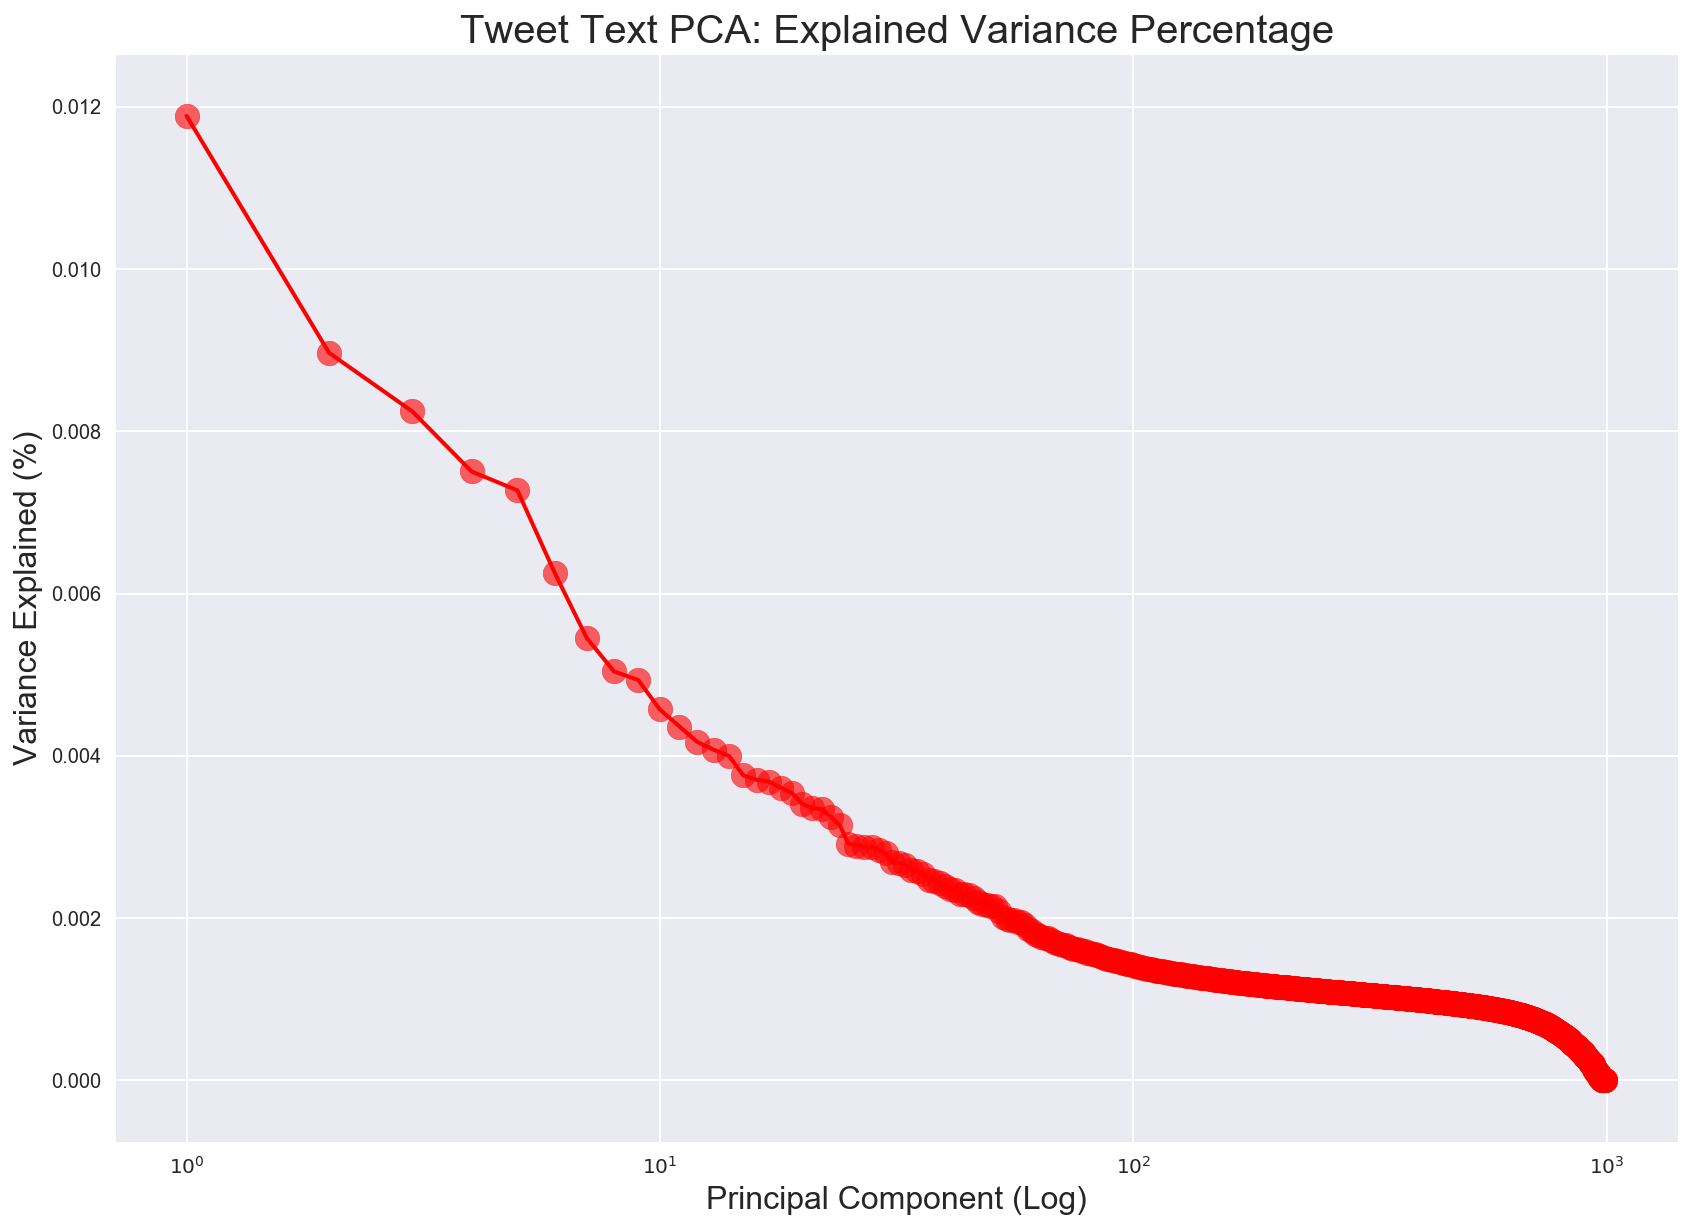

In [48]:
# Plot all individual principle components:

# set an explained variance 
exp_var = pca.explained_variance_ratio_

# plot all principle components
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(range(1, len(exp_var)+1), exp_var,c='r',lw=2,alpha=1)
ax.scatter(range(1, len(exp_var)+1), exp_var,c='r',marker='o', s=150,alpha=0.6)
ax.set_title('Tweet Text PCA: Explained Variance Percentage', fontsize=20)
ax.set_xlabel('Principal Component (Log)', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.xscale('log')
plt.show()

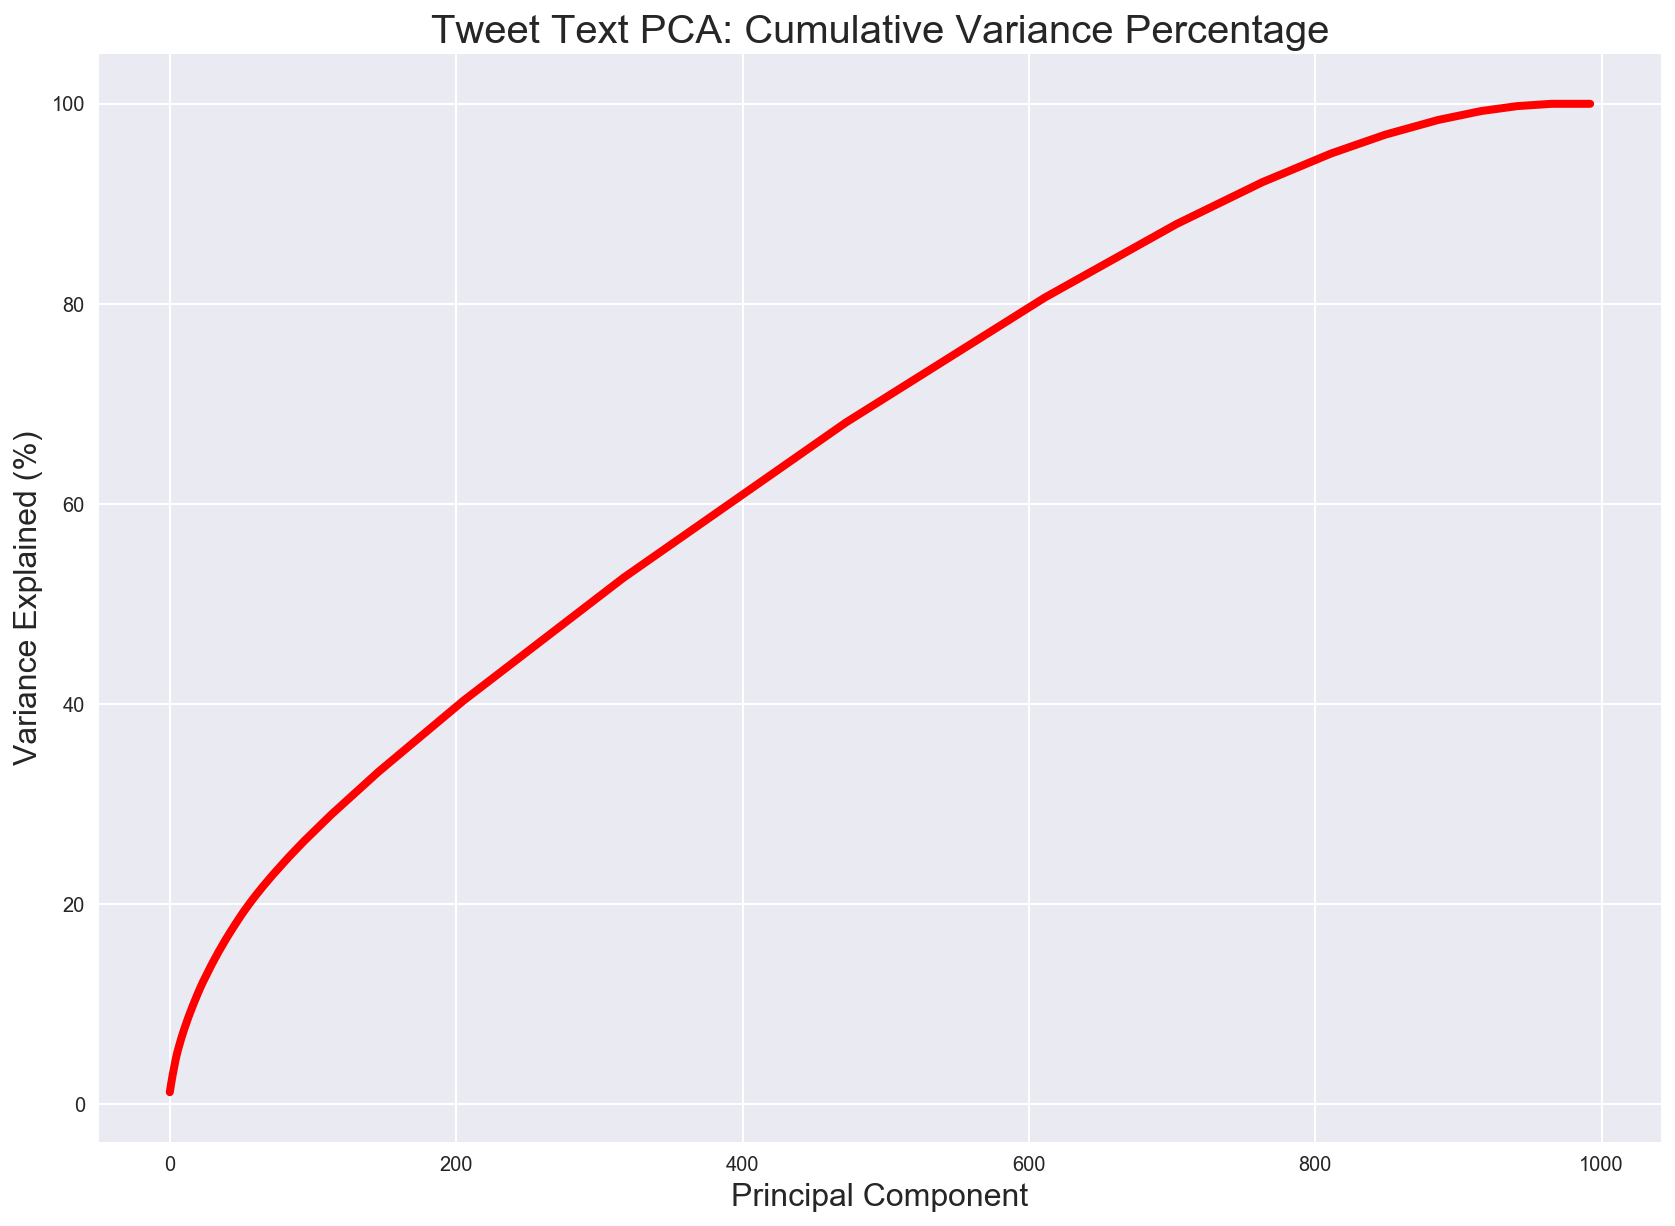

In [56]:
# set cumulative variable
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

# create cumulative plot
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Tweet Text PCA: Cumulative Variance Percentage', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.plot(var1,c='r',lw=4,alpha=1)

**Review:** Although there is little variation in the highest principle components I will investigate the small elbow after the fifth component but reviewing the X's that explain the variance in the top-5 components...

In [57]:
# Create a dataframe with the component names:
components = pd.DataFrame(pca.components_,
                 columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                 index=htt_total.columns)

print ("Top 5 Principle Components and Predictors")
print ("------------------------------------------")
print ("PC1:")
print (components['PC1'].nlargest(10))
print ("------------------------------------------")
print ("PC2:")
print (components['PC2'].nlargest(10))
print ("------------------------------------------")
print ("PC3:")
print (components['PC3'].nlargest(10))
print ("------------------------------------------")
print ("PC4:")
print (components['PC4'].nlargest(10))
print ("------------------------------------------")
print ("PC5:")
print (components['PC5'].nlargest(10))
print ("------------------------------------------")

Top 5 Principle Components and Predictors
------------------------------------------
PC1:
black              0.182906
social             0.098691
streets            0.097879
somerset           0.096018
better             0.091223
navgujaratsamay    0.088767
perfect            0.086091
soar               0.082120
song               0.079578
old                0.078059
Name: PC1, dtype: float64
------------------------------------------
PC2:
break       0.136398
parts       0.128266
mountain    0.104897
powerful    0.104579
north       0.103258
pakistan    0.102601
phone       0.096793
pic         0.091309
rd          0.090555
online      0.090460
Name: PC2, dtype: float64
------------------------------------------
PC3:
bills     0.239319
better    0.233652
stuck     0.140147
snow      0.132232
box       0.129078
big       0.128545
stream    0.121455
beta      0.115606
speed     0.106700
song      0.103487
Name: PC3, dtype: float64
------------------------------------------
PC4:
gmt     

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


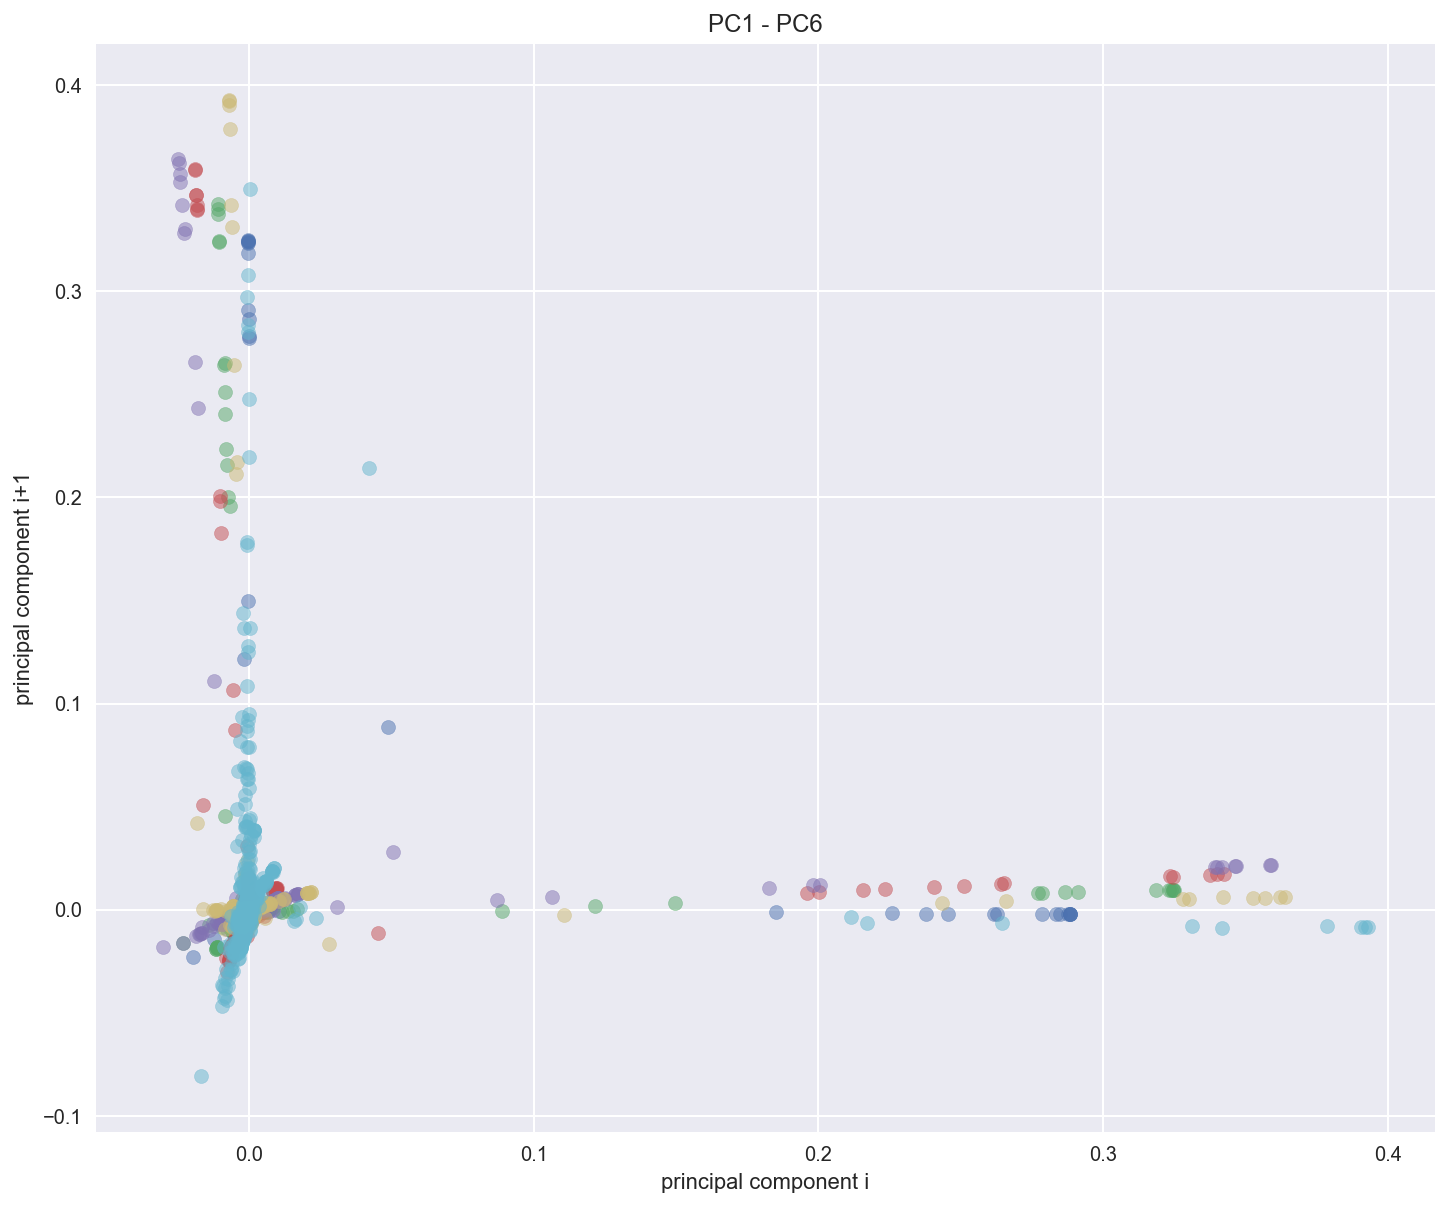

In [30]:
# Plot the top 5 principle components and their predictors

fig, ax = plt.subplots(figsize=(14,14))
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5)
ax.scatter(pca.components_[1], pca.components_[2], alpha=0.5)
ax.scatter(pca.components_[2], pca.components_[3], alpha=0.5)
ax.scatter(pca.components_[3], pca.components_[4], alpha=0.5)
ax.scatter(pca.components_[4], pca.components_[5], alpha=0.5)
ax.set_title('PC1 - PC5')
ax.set_xlabel('principal component i')
ax.set_ylabel('principal component i+1')
ax.legend()
plt.show()

##### PCA Insights:
    
The principle component analysis has provied a useful insight of the variability within my data. The main conclusions are:
- The maximum variance explained for any component is 1.2%, which (generally) is very low.
- The individual explained variance graph suggests every component explains some of the variance.
- The cumulative graph of variance explained indicates that if we were only interested in explaining 90% of the variance, ~800 components would still need to be retained in modelling.
- When investigating the X's that contribute to the individual top-5 components, no single word (x) contributes significantly to the component's overall variance apart from PC1 and the word 'black'.

Due to the above conclusions, I have determined there is little evidence to suggest that removing principle components would signficantly reduce dimensionality enough to improve model performance, therefore all predictors will be used in the modelling.

---

## 3. Hail Modelling

The modelling analysis will investigate classification algorithms appropriate for text classification exercises:
    - Naive Bayes
    - Stochastic Gradient Descent
    - Decision Tree
    - Random Forest (Ensemble)

The hail modelling will be performed on train/test sets of the full dataset (Brisbane and Sydney hail events combined). Following this, I will tune the optimal algorithm type and investigate how well the two hail events perform as train/test samples.

Firstly I will plot the 'hail' class to convey the value of known hail tweets in the full dataset...

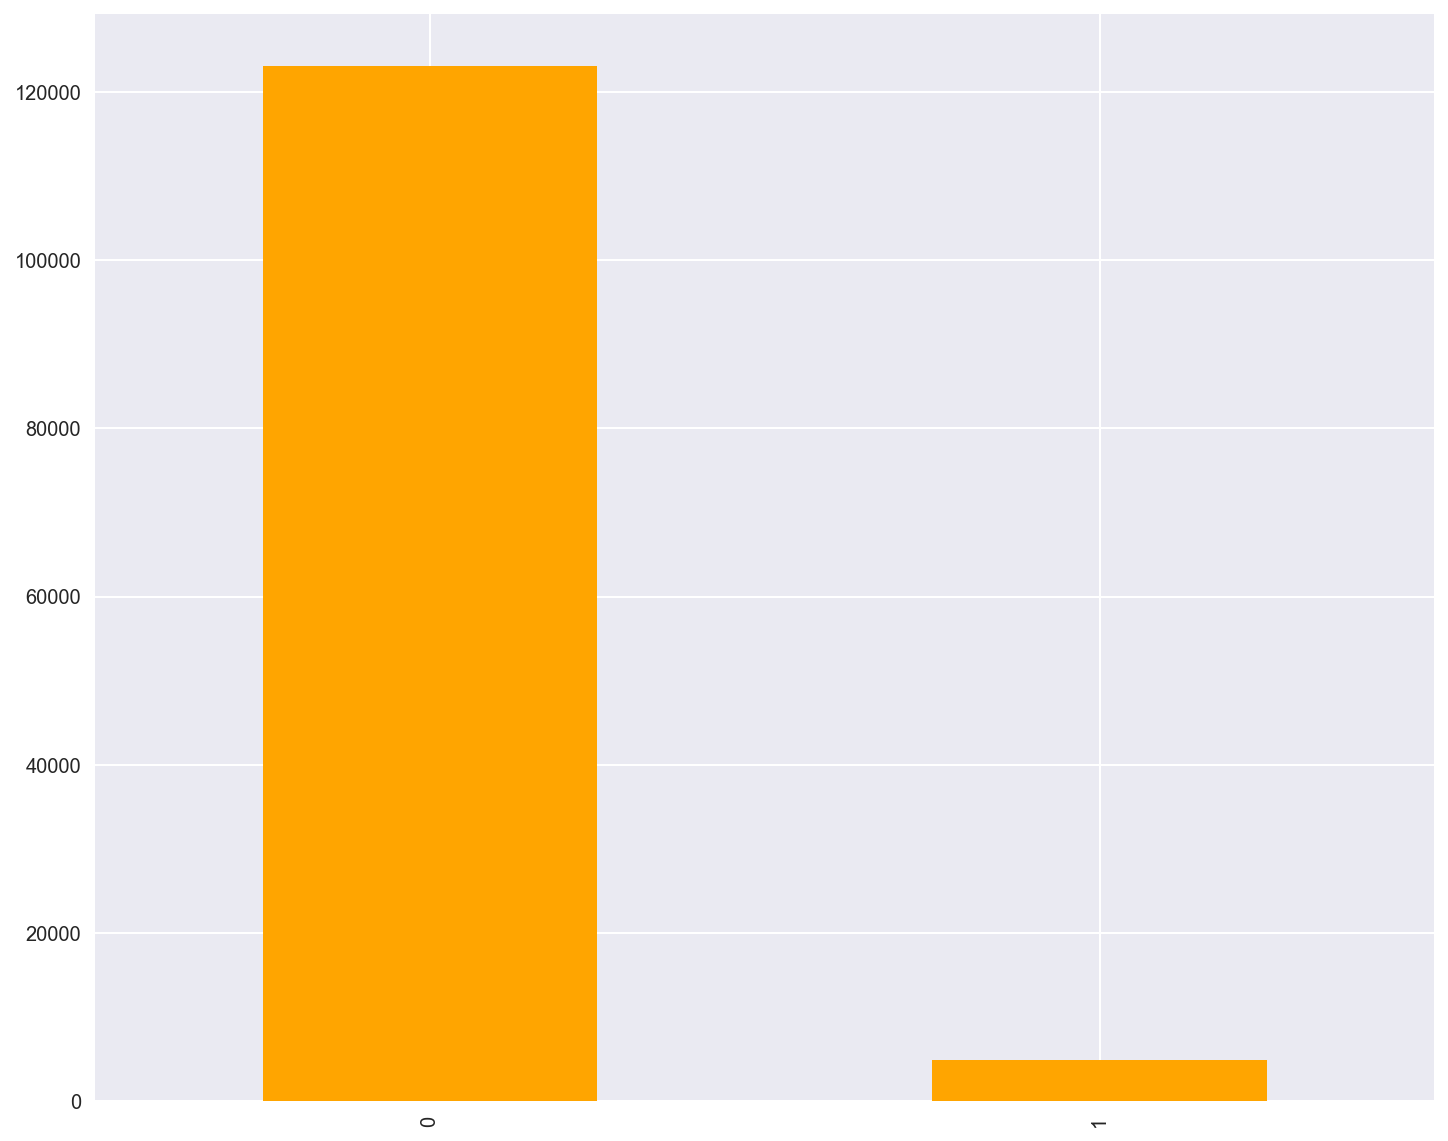

In [14]:
# Plot class counts of Brisbane (1) vs. Sydney (0)

y_total.value_counts().plot(figsize=(12,10),kind='bar',color='orange')

##### Vectorised Text Normalisation

To normalise the vectorised word data the term frequency–inverse document frequency (Tfidf) will be calculated. This is a numerical statistic that intends to reflect how important a word is to a document in a collection or corpus. It is a common transformation used in text classification algorithm development.

_"The term frequency is typically defined as the number of times a given term t (i.e., word or token) appears in a document d (this approach is sometimes also called raw frequency). In practice, the term frequency is often normalized by dividing the raw term frequency by the document length." Sebastian Raschka, 2014_

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

# Transform a count matrix to a normalized tf or tf-idf representation
tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

# Create Train/Test Set
X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.5)

### Naive Bayes Classification

_Probabilistic classifiers based on Bayes' theorem with [naive] independence assumptions..._

In [43]:
from sklearn.naive_bayes import MultinomialNB

# Set MNB classifier and fit with the training data

mnb_tot = MultinomialNB()
mnb_tot.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
# Create function to print modelling results:

def model_results(X,y,model):
    
    # Assess cross validated scores of chosen model
    scores = cross_val_score(model, X, y, cv=5)
    
    # Print all model results:
    print (str(model))
    print ("--------")
    print ("scores:")
    print (scores)
    print ("--------")
    print ("avg score:")
    print (sum(scores)/len(scores))
    print ("--------")
    
    # Predict y values based on fitted classication
    yhat = model.predict(X)

    # Sum all the true/false positives/negatives combinations
    tp = np.sum((y == 1) & (yhat == 1))
    fp = np.sum((y == 0) & (yhat == 1))
    tn = np.sum((y == 0) & (yhat == 0))
    fn = np.sum((y == 1) & (yhat == 0))

    # convert the predicted and actual values to a confusion array

    confusion_array = np.array(confusion_matrix(y, yhat, labels=[1,0]))

    confusion = pd.DataFrame(confusion_array, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
    
    # Print classifier evaluation metrics
    print ("confusion matrix")
    print (confusion)
    print ("--------")
    print ("accuracy:", accuracy_score(y, yhat))
    print ("false positive rate", (float(fp) / (tn + fp))
    print ("specificity", float(tn) / (tn + fp))
    print ("--------")
    print (classification_report(y, yhat))

In [45]:
# MNB evaluation with model_results function

model_results(X_test,y_test,mnb_tot)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
--------
scores:
[ 0.9675      0.96726307  0.96796625  0.96890382  0.96632286]
--------
avg score:
0.96759119967
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                484               1992
no hail              50              61469
--------
accuracy: 0.968091257129
false positive rate 0.000812757034412
specificity 0.999187242966
--------
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     61519
          1       0.91      0.20      0.32      2476

avg / total       0.97      0.97      0.96     63995



In [46]:
# Review a dataframe of the MNB log-probability features

mb_coefficients = pd.DataFrame(data=mnb_tot.feature_log_prob_,columns=htt_total.columns)
mb_coefficients = mb_coefficients.T
mb_coefficients.sort_values(1, ascending=False, inplace=True)
mb_coefficients.head(20)

,0,1
sentiment,-1.532503,-1.719315
storm,-2.465421,-2.271702
massive,-6.473676,-4.286635
slammed,-11.196751,-4.363792
severe,-6.331966,-4.421854
worst,-7.296895,-4.482023
super,-7.511925,-4.507222
rain,-5.326547,-4.592421
australia,-7.386169,-4.598539
causes,-7.289970,-4.676045


**Result:** the accuracy of the naive bayes classifier is very high however the percentage of true postives to false negatives is low (20%), so whilst the accuracy is good the model does not classify well. This is supported by a low f1 value for the 1-class.

### Stochastic Gradient Descent Classification

_An optimization algorithm used to find the values of parameters of a function that minimizes a loss function._

In [47]:
from sklearn.linear_model import SGDClassifier

parameters = {
    'alpha': (0.0001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'n_iter': (10, 50, 80),
}

# Call SGD and gridsearch the hyperparameters
sgd = SGDClassifier(loss='modified_huber') # MH brings tolerance to outliers as well as probability estimates
sgd_gs = GridSearchCV(sgd, parameters, cv=5, verbose=1, refit=True)

# Fit optimal SGD with training data
sgd_gs.fit(X_train, y_train)

print (sgd_gs.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 0.0001, 'n_iter': 10, 'penalty': 'l2'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   25.0s finished


In [48]:
# observing the largest coefficients / SGD feature weights

best_sgd = sgd_gs.best_estimator_

coef_df_overall = pd.DataFrame({
        'coefficient':np.abs(best_sgd.coef_[0]),
        'feature':htt_total.columns})

coef_df_overall.sort('coefficient',ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,coefficient,feature
757,2.752601,sized
761,2.587664,slammed
141,2.477671,chaos
756,1.668844,size
582,1.640638,nsw
441,1.439586,large
847,1.195647,tens
279,1.153987,flood
963,1.145041,winds
41,1.010006,australia


In [49]:
# SGD evaluation with model_results function

model_results(X_test,y_test,sgd_gs)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   18.2s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   16.1s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   14.5s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   14.2s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': (0.0001, 1e-06), 'penalty': ('l2', 'elasticnet'), 'n_iter': (10, 50, 80)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)
--------
scores:
[ 0.96867187  0.97054457  0.9683569   0.97054457  0.96866698]
--------
avg score:
0.969356980938
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                624               1852
no hail             112              61407
--------
accuracy: 0.969310102352
false positive rate 0.00182

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   14.6s finished


**Result:**

- MNB: 0.9675
- SGD: 0.9693
    
An improved accuracy score compared to MNB and a lower type 2 error is observed with SGD classification. However the false positive rate is slightly higher.

### Decision Tree Classification

_Decision tree classifiers organized a series of test questions and conditions in a tree structure, learning simple decision rules inferred from the data features._

In [50]:
# Decision Tree gridsearch to get the optimal decision tree model

dtc_params = {
    'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]}


dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, refit=True)

dtc_gs.fit(X_train, y_train)

dtc_best = dtc_gs.best_estimator_

print (dtc_gs.best_params_)

Fitting 5 folds for each of 847 candidates, totalling 4235 fits


[Parallel(n_jobs=1)]: Done 4235 out of 4235 | elapsed:  8.3min finished


{'max_depth': 10, 'max_features': None, 'min_samples_split': 5}


In [51]:
# set dtc with hyperparameters and fit with training data

dtr_ds = DecisionTreeClassifier(max_features=None,min_samples_split=5,max_depth=10)

dtr_ds.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [52]:
# Extract the top features from the decision tree classifier.

top_features_DS = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':dtr_ds.feature_importances_})

top_features_DS.sort_values('importance', ascending=False, inplace=True)
top_features_DS.head(10)

,feature,importance
761,slammed,0.246476
141,chaos,0.142138
757,sized,0.117929
963,winds,0.073745
756,size,0.068885
131,causes,0.053045
994,sentiment,0.042054
582,nsw,0.034259
41,australia,0.033884
741,severe,0.033723


In [53]:
# DTC evaluation with model_results function

model_results(X_test,y_test,dtr_ds)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
--------
scores:
[ 0.96695312  0.97007579  0.96812251  0.96913821  0.96812002]
--------
avg score:
0.968481930884
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                605               1871
no hail             109              61410
--------
accuracy: 0.969060082819
false positive rate 0.00177181033502
specificity 0.998228189665
--------
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     61519
          1       0.85      0.24      0.38      2476

avg / total       0.97      0.97      0.96     63995



**Result:**

- MNB: 0.9675
- SGD: 0.9693
- DTC: 0.9684
    
An reduction in accuracy score is observed for DT compared to SGD along with a slightly lower type 2 error. The false positive rate is lower but overall, it performs similarly to the SGD classification.

### Random Forest Classification

_An ensemble learning method for classification that constructs a multitude of decision trees at training time and outputs the class that is the mode of the classification._

In [54]:
from sklearn.ensemble import RandomForestClassifier

# build a RF classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search and fit with training data
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_train, y_train)

rfc_gs.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [55]:
# RFC evaluation with model_results function

model_results(X_test,y_test,rfc_gs)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
--------
scores:
[ 0.97015625  0.97124775  0.97046644  0.97273224  0.97054227]
--------
avg score:
0.971028992672
--------
confusion matrix
         predicted_hail  predicted_no_hail
hail                796        

**Result:**

- MNB: 0.9675
- SGD: 0.9693
- DTC: 0.9684
- RFC: 0.9710

The Random Forest ensemble model is the best performing classifcation algorithm. It has the highest accuracy score at 0.971, it predicts the highest number of true postives of the training data and as such, has the best recall and f1 scores. The only area it falls down is the highest false positive rate of the four algorithms.

#### Plot all ROC Curves for models

In [61]:
# Plot the ROC curve:

from sklearn.metrics import roc_curve, auc

yhat_mnb = mnb_tot.predict_proba(X_test)
yhat_sgd = sgd_gs.predict_proba(X_test)
yhat_dtc = dtr_ds.predict_proba(X_test)
yhat_rfc = rfc_gs.predict_proba(X_test)

# naive bayes roc/auc calculation
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, yhat_mnb[:,1])
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

# sgd roc/auc calculation
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, yhat_sgd[:,1])
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# decision tree roc/auc calculation
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, yhat_dtc[:,1])
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

# random forest roc/auc calculation
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, yhat_rfc[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

plt.figure(figsize=[12,12])

plt.plot(fpr_mnb, tpr_mnb, label='mnb' % roc_auc_mnb, linewidth=3)
plt.plot(fpr_sgd, tpr_sgd, label='sgd' % roc_auc_sgd, linewidth=3)
plt.plot(fpr_dtc, tpr_dtc, label='dtc' % roc_auc_dtc, linewidth=3)
plt.plot(fpr_rfc, tpr_rfc, label='rfc' % roc_auc_rfc, linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver Operating Characteristic: Hail Classifier', fontsize=15)
plt.legend(loc="lower right")
plt.show()

NameError: name 'mnb_tot' is not defined

**Note:** The ROC plot outlines the results of the classifications well - the most optimal model, with the largest ROC curve area, is the Random Forest algorithm, followed by stochastic gradient descent and naive bayes.

###  4. Model Tuning and Evaluation

I will now determine the hyperparameters for our random forest classifier algorithm using using our full dataset. This will ensure the optimal parameters are selected before we evaluate our model against the Brisbane and Sydney hails events.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_total_tf, y_total)

rfc_gs

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
rfc_gs.best_score_

0.96793474439209615

In [42]:
# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc_gs.predict(X_total_tf)
yhat_total_rfc_pp = rfc_gs.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc

,predicted_hail,predicted_no_hail
hail,3908,997
no hail,91,122993


In [ ]:
# Classification report for optimal RFC

print(classification_report(y_total, yhat_total_rfc))

**Result:** 

When optimised with the full dataset, the random forest classifier performs very well at predicting y values. This is generally expected as it tests the same data used for training, however it provides more confidence in our algorithm's _predictability_.

I will now outline evaluate the optimal random forest model using our train/test hail event subsets...

### Brisbane (Train) / Sydney (Test) - Random Forest Classification

In [58]:
# transform our X (text) datasets
tf_transformer_bris = TfidfTransformer(use_idf=False).fit(htt_bris)
tf_transformer_syd = TfidfTransformer(use_idf=False).fit(htt_syd)

X_bris_tf = tf_transformer.transform(htt_bris)
X_syd_tf = tf_transformer.transform(htt_syd)

In [63]:
# Fit our optimal random forest model with or brisbane dataset

rfc_gs.fit(X_bris_tf, y_bris)

# Predict our y-values

yhat_syd_rfc = rfc_gs.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_gs.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])

# print classification evaluators
print (confusion_rfc_syd)
print (classification_report(y_syd, yhat_syd_rfc)))

,predicted_hail,predicted_no_hail
hail,102,3073
no hail,70,78215


### Sydney (Train) / Brisbane (Test) - Random Forest Classification

In [64]:
# Extract the top features from the random forest classifier.
rfc_gs.fit(X_syd_tf, y_syd)

# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_gs.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_gs.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])

# print classification evaluators
print (confusion_rfc_bris)
print (classification_report(y_bris, yhat_bris_rfc)))

,predicted_hail,predicted_no_hail
hail,1274,456
no hail,9,44790


### Hail Model Evaluation Conclusion

- The random forest classification algorithm, once tuned, performs very well at predicting hail classes from the text used in the tweets.
- The true positive percentage (80%) is much higher than the train/testing method used to originally investigate the other classification methods. Whilst this is expected due to training the data on the full dataset, such a high true postive rate is a very positive outcome and gives confidence in the selected hyperparameters.
- When the Brisbane data (the severe event) is used to train the algorithm, and Sydney data tests, the model performs poorly with a very low true positive rate.
- Inversely, when the opposite is evaluated (Sydney train, Brisbane test) the model performs much better. This implies the Brisbane dataset likely drives the performance of the algorithm and the tweets from that event contain terms that are the best predictors of hail. This is a strong indication that the Brisbane Hail event was more severe.

**Notebook 4** investigates the severity further, as well as second type of natural catastrophe...

### Link to [Notebook 4](capstone_technical_report_4_SeverityAndEQModelling.ipynb)

----